In [125]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import casacore
import casacore.tables as pt
import pandas as pd
from sklearn import cluster
from sklearn import metrics
plt.rcParams['figure.figsize']=[10,8]
plt.rcParams['font.size']=14

In [127]:
#fname = "/data001/scratch/kkozarev/EVENT_20170804/MS/SUN/L602826_SAP000_SB052_uv_autoweight.MS"
fname = "/data/LOFAR/events/20170804/L602826_SAP000_SB154_uv_autoweight.MS"

ant = pt.table(fname+"/ANTENNA").getcol("NAME")
cs = [i for i,j in enumerate(ant) if "CS" in j] #only collect data of CS for now

Successful readonly open of default-locked table /data/LOFAR/events/20170804/L602826_SAP000_SB154_uv_autoweight.MS/ANTENNA: 10 columns, 35 rows


In [153]:
blines = []
data = []
bldata = []
cdata = []
blcdata = []
for idx1,ant1 in enumerate(cs):
    data.append([])
    cdata.append([])
    for ant2 in cs[idx1+1:]:
        blines.append( ant[ant1]+"_"+ant[ant2])
        #print (blines[-1])
        myt = pt.taql("select from $fname where ANTENNA1==$ant1 and ANTENNA2==$ant2")
        flags = myt.getcol("FLAG")
        datacol = myt.getcol("DATA")
        corrected_datacol = myt.getcol("CORRECTED_DATA")
        break
        data[-1].append(np.ma.array(datacol, mask=flags))
        cdata[-1].append(np.ma.array(corrected_datacol, mask=flags))



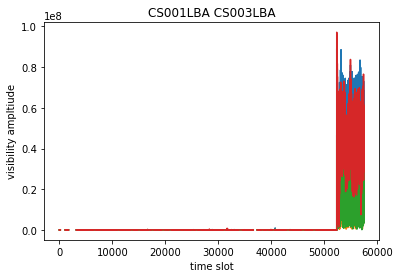

In [4]:
#now plot the data vs. time, e.g. station 0 and 2
st1=0;st2=2;
plt.plot(np.abs(cdata[st1][st2][:,0])) # different colors is different polarisations (XX,XY,YX,YY)
plt.title(ant[st1]+" "+ant[st2])
plt.xlabel("time slot")
plt.ylabel("visibility ampltiude")
plt.show()

In [94]:
#THIS CODE WILL REPLACE THE FLAGS OF THE DATA WITH THE NEW CUT-OFFS - ONLY FOR XX correlation
vmax2=pd.read_pickle('visibility_cutoff_xx.p')
ntimes=vmax2.shape[0]

# to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
myt = pt.table(fname,readonly=False)
flags = myt.getcol("FLAG")
desc=myt.getcoldesc("FLAG")
cdata = myt.getcol("CORRECTED_DATA")

newflags=flags.copy()
stride=630 #the number of antenna station combinations in this MS (for the CS stations only)
#Apply time-dependent cut-off flagging
for tt in range(ntimes):
    newflags[tt*stride:(tt+1)*stride,0,0] = np.abs(cdata[tt*stride:(tt+1)*stride,0,0]) > vmax2.values[tt][0]
newflags = np.logical_or(flags,newflags)
if "OLDFLAGS" in myt.colnames():
    print ("column OLDFLAGS already existing, not overwriting")
else:
   desc['name']="OLDFLAGS"
   myt.addcols(desc)
   myt.putcol("OLDFLAGS",flags)
   myt.putcol("FLAG",newflags)
myt.close()

Successful read/write open of default-locked table /data/L602826_SAP000_SB154_uv_autoweight_test.MS: 27 columns, 36237600 rows


In [83]:
fname = "/data/L602826_SAP000_SB154_uv_autoweight_test.MS"
# to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
myt = pt.table(fname) #,readonly=False
flags = myt.getcol("FLAG")

Successful readonly open of default-locked table /data/L602826_SAP000_SB154_uv_autoweight_test.MS: 27 columns, 36237600 rows


In [56]:
time=myt.getcol('TIME')
tt=1
stride=630
time[tt*stride:(tt+1)*stride]-time[tt*stride]

1260


In [57]:
np.abs(cdata[0:630,0,0]) > 2000

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,

In [46]:
if False:
    # to flag the data you could update the flag column, you might want to keep the old flags however
    # in order to be able to convert back
    myt = pt.table(fname,readonly=False)
    flags = myt.getcol("FLAG")
    desc=myt.getcoldesc("FLAG")

    cdata = myt.getcol("CORRECTED_DATA")
    newflags = np.abs(cdata)>1000 #just a guess, please inspect the data first before setting the clip_value
    newflags = np.logical_or(flags,newflags)
    if "OLDFLAGS" in myt.colnames():
        print ("column OLDFLAGS already existing, not overwriting")
    else:
       desc['name']="OLDFLAGS"
       myt.addcols(desc)
       myt.putcol("OLDFLAGS",flags)
       myt.putcol("FLAG",newflags)
    myt.close()

5008567500.125174

In [124]:
import random
tmpdir='tmpdir_{:05d}/'.format(random.randint(0,99999))
print(tmpdir)

tmpdir_00015/


Successful read/write open of default-locked table /data/L602826_SAP000_SB154_uv_autoweight_test.MS: 28 columns, 36237600 rows


(48000, 52000)

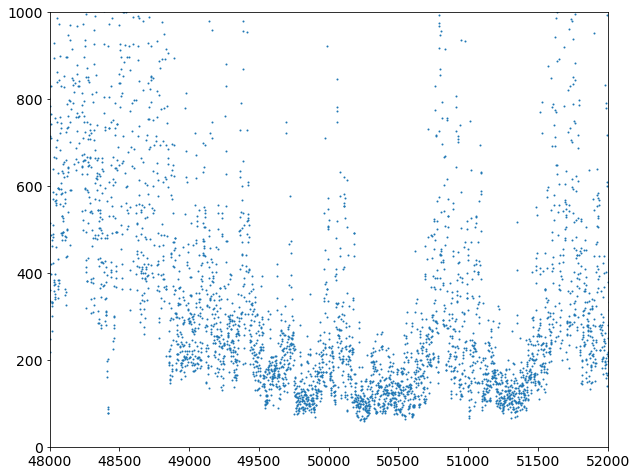

In [117]:
fname = "/data/LOFAR/events/20170804/L602826_SAP000_SB154_uv_autoweight.MS"
# to flag the data you could update the flag column, you might want to keep the old flags however in order to be able to convert back
myt = pt.table(fname,readonly=False)
flags = myt.getcol("FLAG")
tmp=vmax2.values.astype(np.float32)
plt.scatter(range(ntimes),tmp,s=1)
plt.ylim((0,1000))
plt.xlim((48000,52000))



In [157]:
#Develop pandas dataframes for each cross-correlation before and after calibration
#They hold the visibility amplitudes for all LOFAR baselines over all timesteps of observation.

blines = []
#data = []
#bldata = []
#cdata = []
#blcdata = []
#XX,XY,YX,YY
dfxx = pd.DataFrame()
dfxy = pd.DataFrame()
dfyx = pd.DataFrame()
dfyy = pd.DataFrame()
cdfxx = pd.DataFrame()
cdfxy = pd.DataFrame()
cdfyx = pd.DataFrame()
cdfyy = pd.DataFrame()
fdfxx = pd.DataFrame() 
fdfxy = pd.DataFrame() 
fdfyx = pd.DataFrame()
fdfyy = pd.DataFrame() 
for idx1,ant1 in enumerate(cs):
    #data.append([])
    #cdata.append([])
    for ant2 in cs[idx1+1:]:
        column=ant[ant1]+"_"+ant[ant2]
        blines.append(column)
        myt = pt.taql("select from $fname where ANTENNA1==$ant1 and ANTENNA2==$ant2")
        flags = myt.getcol("FLAG")
        datacol = myt.getcol("DATA")
        corrected_datacol = myt.getcol("CORRECTED_DATA")
        fdfxx[column]=flags[:,0,0]
        fdfxy[column]=flags[:,0,1]
        fdfyx[column]=flags[:,0,2]
        fdfyy[column]=flags[:,0,3]
        cdfxx[column]=np.abs(np.ma.array(corrected_datacol[:,0,0], mask=flags[:,0,0])).astype(np.float32)
        dfxx[column]=np.abs(np.ma.array(datacol[:,0,0], mask=flags[:,0,0])).astype(np.float32)
        cdfxy[column]=np.abs(np.ma.array(corrected_datacol[:,0,1], mask=flags[:,0,1])).astype(np.float32)
        dfxy[column]=np.abs(np.ma.array(datacol[:,0,1], mask=flags[:,0,1])).astype(np.float32)
        cdfyx[column]=np.abs(np.ma.array(corrected_datacol[:,0,2], mask=flags[:,0,2])).astype(np.float32)
        dfyx[column]=np.abs(np.ma.array(datacol[:,0,2], mask=flags[:,0,2])).astype(np.float32)
        cdfyy[column]=np.abs(np.ma.array(corrected_datacol[:,0,3], mask=flags[:,0,3])).astype(np.float32)
        dfyy[column]=np.abs(np.ma.array(datacol[:,0,3], mask=flags[:,0,3])).astype(np.float32)
        #data[-1].append(np.ma.array(datacol, mask=flags))
        #cdata[-1].append(np.ma.array(corrected_datacol, mask=flags))
fdfxx.to_pickle('./L602826_SAP000_SB154_uv_autoweight_fxx.p')     
fdfxy.to_pickle('./L602826_SAP000_SB154_uv_autoweight_fxy.p') 
fdfyx.to_pickle('./L602826_SAP000_SB154_uv_autoweight_fyx.p') 
fdfyy.to_pickle('./L602826_SAP000_SB154_uv_autoweight_fyy.p') 
cdfxx.to_pickle('./L602826_SAP000_SB154_uv_autoweight_cdxx.p')
cdfxy.to_pickle('./L602826_SAP000_SB154_uv_autoweight_cdxy.p')
cdfyx.to_pickle('./L602826_SAP000_SB154_uv_autoweight_cdyx.p')
cdfyy.to_pickle('./L602826_SAP000_SB154_uv_autoweight_cdyy.p')
dfxx.to_pickle('./L602826_SAP000_SB154_uv_autoweight_dxx.p')
dfxy.to_pickle('./L602826_SAP000_SB154_uv_autoweight_dxy.p')
dfyx.to_pickle('./L602826_SAP000_SB154_uv_autoweight_dyx.p')
dfyy.to_pickle('./L602826_SAP000_SB154_uv_autoweight_dyy.p')

In [128]:
cdfxx=pd.read_pickle('./L602826_SAP000_SB154_uv_autoweight_cdxx.p')
fdfxx=pd.read_pickle('./L602826_SAP000_SB154_uv_autoweight_fxx.p')
ntimes=cdfxx.values.shape[0]
nbaselines=cdfxx.values.shape[1]

In [249]:
#Loop over a number of timesteps - 100 to start with, and do K-Means clustering over all baselines
vmax=[]
for tt in range(ntimes):
    data = cdfxx.loc[tt].values.reshape(-1, 1)
    kmeans=cluster.KMeans(n_clusters=5)
    model=kmeans.fit(data)
    # Get cluster assignment labels
    labels = kmeans.labels_
    # Format results as a DataFrame
    #results = pd.DataFrame([labels]).T
    #u_labels = np.unique(results[1].values)
    cluster_centers = kmeans.cluster_centers_
    u_labels=cluster_centers[:,0].argsort()
    #Metrics scores
    #sscore=metrics.silhouette_score(data, labels, metric = 'euclidean')
    #chscore=metrics.calinski_harabasz_score(data, labels)
    #Record the 
    vmax.append(np.nanmax(data[labels == u_labels[1]]))
wsclean -j 40 -mem 80  -no-reorder -no-update-model-required -mgain 0.6 -weight briggs 1 -multiscale -maxuvw-m 3200 -size 2048 2048 -scale 15asec  -pol I -data-column CORRECTED_DATA -niter 3000 -intervals-out 100 -interval  48500 52000 -fit-beam -name fits_50MHz/lownoise/SB154_quiet MS/SUN/L602826_SAP000_SB154_uv_autoweight.MS

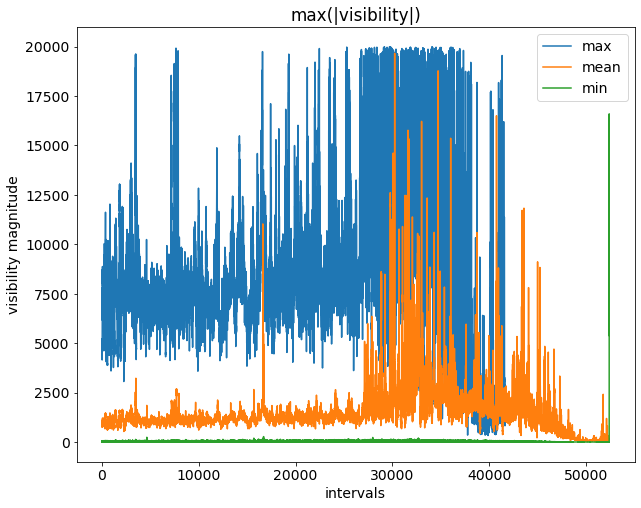

In [150]:
origmax=cdfxx.max(axis=1).values
origmean=cdfxx.mean(axis=1).values
origmin=cdfxx.min(axis=1).values
plt.plot(origmax[origmax < 2.e4],label='max')
plt.plot(origmean[origmean < 2.e4],label='mean')
plt.plot(origmin[origmin < 2.e4],label='min')
plt.xlabel('intervals')
plt.ylabel('visibility magnitude')
plt.title('max(|visibility|)')
plt.legend()
plt.savefig('original_visibility_amplitudes.png',bbox_inches='tight')

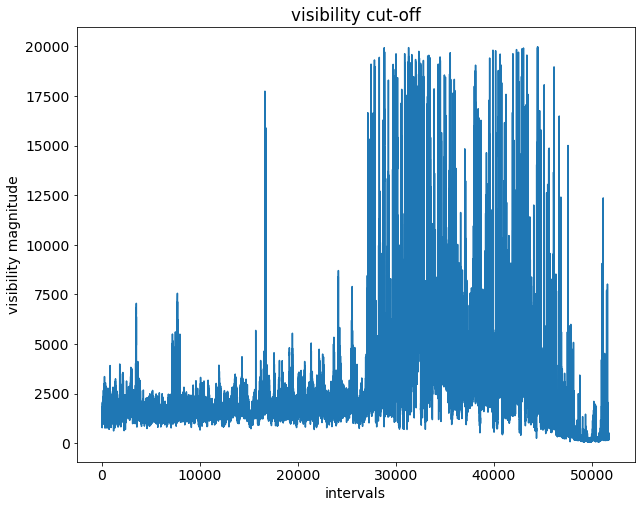

In [149]:
vmax=np.array(vmax2)
plt.plot((vmax[vmax < 20000.]))
plt.xlabel('intervals')
plt.ylabel('visibility magnitude')
plt.title('visibility cut-off')
plt.savefig('visibility_cutoff_limited.png',bbox_inches='tight')

In [278]:
#filehandler = open('visibility_cutoff.p',"wb")
#pickle.dump(vmax,filehandler)
vdf=pd.DataFrame(vmax)
vdf.to_pickle('visibility_cutoff.p')

In [243]:
#TESTING for one timestep:
tt=2
data = cdfxx.loc[tt].values.reshape(-1, 1)
kmeans=cluster.KMeans(n_clusters=5)
model=kmeans.fit(data)
# Get cluster assignment labels
labels = kmeans.labels_
# Format results as a DataFrame
#results = pd.DataFrame([labels]).T
cluster_centers = kmeans.cluster_centers_
u_labels=cluster_centers[:,0].argsort()
#Metrics scores
sscore=metrics.silhouette_score(data, labels, metric = 'euclidean')
chscore=metrics.calinski_harabasz_score(data, labels)
maxmag=np.nanmax(data[labels == u_labels[1]])
#print(cluster_centers)
print(maxmag)
#print(cluster_centers[u_labels])
#print((sscore,chscore))

1096.41


In [239]:
for u_label in u_labels:
    print(u_label)
    print(cluster_centers[u_label])
    print((np.nanmin(data[labels == u_label]),np.nanmax(data[labels == u_label])))
print(np.nanmax(data[labels == u_labels[1]]))

1
[302.9206]
(17.02697, 538.31866)
3
[776.3163]
(545.9284, 1151.9883)
0
[1533.2803]
(1164.322, 1974.1278)
4
[2842.8855]
(2288.5571, 3359.2483)
2
[3919.5583]
(3491.477, 4443.5615)
1151.9883


In [179]:
#Recording the metrics for a variety of k-values for comparison.
#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []
chscore = []
sscore = []
K = range(2,15)
for k in K:
    kmeans = cluster.KMeans(n_clusters=k)
    model = kmeans.fit(data)
    labels = kmeans.labels_
    sum_of_squared_distances.append(kmeans.inertia_)
    sscore.append(metrics.silhouette_score(data, labels, metric = 'euclidean'))
    chscore.append(metrics.calinski_harabasz_score(data, labels))


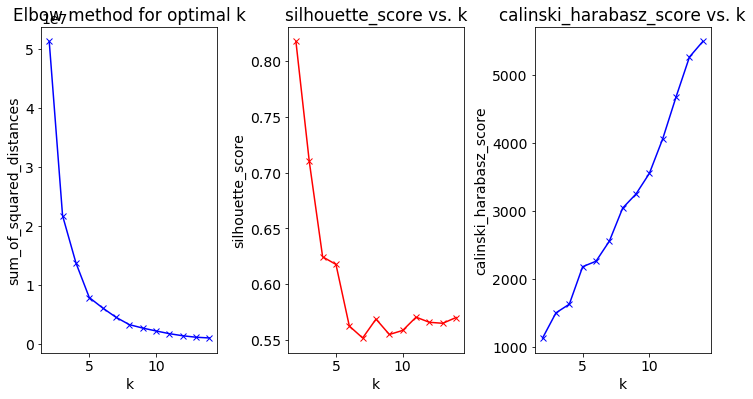

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
plt.subplot(131)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.subplot(132)
plt.plot(K, sscore, 'rx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_score vs. k')
plt.subplot(133)
plt.plot(K, chscore, 'bx-')
plt.xlabel('k')
plt.ylabel('calinski_harabasz_score')
plt.title('calinski_harabasz_score vs. k')
fig.subplots_adjust(wspace=.4)
plt.savefig('k_value_comparisons.png',bbox_inches='tight')
plt.show()

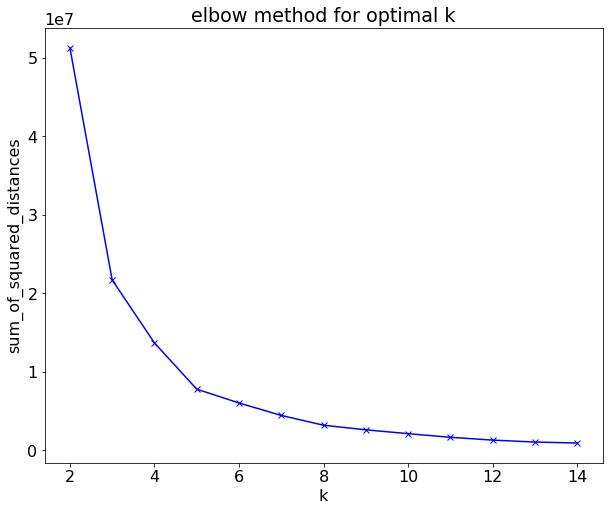

In [186]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.savefig('elbow_method_optimal_k.png',bbox_inches='tight')
plt.show()

0
520.61676
3
4443.5615
2
1096.41
4
1974.1278
1
3359.2483


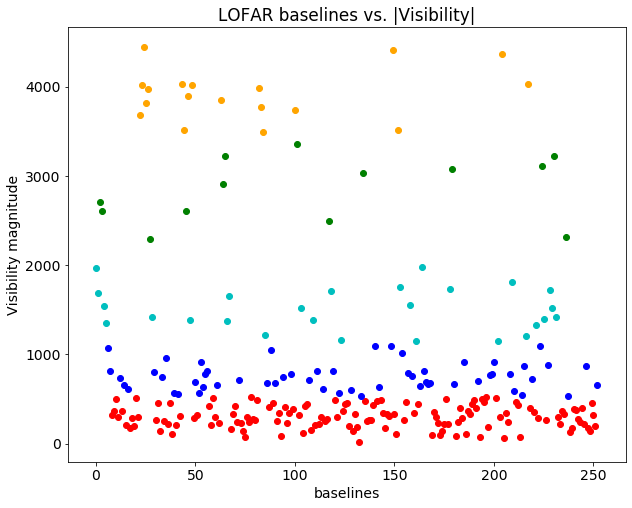

In [230]:
baselines=np.arange(nbaselines)
colors=['r','g','b','orange','c']

for u_label in u_labels:
    print(u_label)
    print(np.nanmax(data[labels == u_label]))
    plt.scatter(baselines[labels == u_label],data[labels == u_label],c=colors[u_label])
plt.xlabel('baselines')
plt.ylabel('Visibility magnitude')
plt.title('LOFAR baselines vs. |Visibility|')
plt.savefig('baselines_visibility_clusters.png',bbox_inches='tight')

#print(u_labels[0])